In [1]:
from util import *
from glob import glob
import matplotlib.pyplot as plt
from shapely import wkt
pd.set_option("display.max_columns", None)

In [2]:
gdf = gpd.read_file(f"Manuwatu_Test/transects_intersects_20240315_120828.geojson")
gdf["Date"] = pd.to_datetime(gdf.ShorelineID, dayfirst=True, format='mixed')
gdf["Year"] = gdf.Date.dt.year
gdf["YearsSinceBase"] = (gdf.Date - pd.Timestamp(1800, 1, 1)).dt.days / 365.25
gdf["YearsUntilFuture"] = (
    pd.Timestamp(2100, 1, 1) - gdf.Date
    ).dt.days / 365.25
gdf.Date = gdf.Date.astype(str)
gdf

#Why are distances negative? Because baseline is now offshore i.e zero is in the ocean?
#Do we need to ignore the sign? Erosion projection needs to show more negative distance (move onshore), while accretion needs to go in less negative (move offshore)

,TransectID,ShorelineID,BaselineID,Distance,IntersectX,IntersectY,Uncertainty,geometry,Date,Year,YearsSinceBase,YearsUntilFuture
0,1,05/12/2020,0,-30.72,1.664823e+06,5.652036e+06,10.00,POINT (1664822.752 5652035.621),2020-12-05,2020,220.922656,79.071869
1,1,11/02/2017,0,-29.69,1.664822e+06,5.652035e+06,10.00,POINT (1664821.739 5652035.474),2017-02-11,2017,217.108830,82.885695
2,1,08/11/1970,0,-27.86,1.664820e+06,5.652035e+06,2.63,POINT (1664819.922 5652035.211),1970-11-08,1970,170.847365,129.147159
3,1,19/09/1955,0,-25.63,1.664818e+06,5.652035e+06,2.68,POINT (1664817.715 5652034.890),1955-09-19,1955,155.709788,144.284736
4,2,05/12/2020,0,-31.94,1.664830e+06,5.651936e+06,10.00,POINT (1664830.066 5651936.243),2020-12-05,2020,220.922656,79.071869
...,...,...,...,...,...,...,...,...,...,...,...,...
9214,1925,23/01/2016,244,-39.52,1.904293e+06,5.511354e+06,1.02,POINT (1904293.154 5511353.967),2016-01-23,2016,216.054757,83.939767
9215,1925,31/03/1944,244,-29.47,1.904294e+06,5.511344e+06,2.27,POINT (1904293.505 5511343.923),1944-03-31,1944,144.240931,155.753593
9216,1926,29/04/2021,244,-36.22,1.904393e+06,5.511358e+06,1.02,POINT (1904392.891 5511358.332),2021-04-29,2021,221.319644,78.674880
9217,1926,23/01/2016,244,-36.58,1.904393e+06,5.511359e+06,1.02,POINT (1904392.878 5511358.698),2016-01-23,2016,216.054757,83.939767


In [3]:
#DSASv6 does not produce an azimuth attribute in the transect file so either need to calculate geometry in ArcGIS Pro or add code
transect_metadata = get_transect_metadata(f"Manuwatu_Test/t10_transects_azi.shp")

In [4]:
linear_models = fit(gdf, transect_metadata)
rolled_slopes = linear_models.groupby("group").slope.rolling(10, min_periods=1).mean().dropna().reset_index(level=0)
linear_models.slope = rolled_slopes.slope
linear_models.dropna(inplace=True)
linear_models

c:\Users\lalit\anaconda3\envs\environment\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\lalit\anaconda3\envs\environment\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\lalit\anaconda3\envs\environment\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


,TransectID,slope,intercept,group,r2_score,mae,mse,rmse
0,1,-0.065571,-15.941371,1,0.926099,0.504336,0.276915,0.526227
1,2,-0.090784,-11.259434,2,0.957393,0.507380,0.296034,0.544090
2,3,-0.055217,-15.562882,3,0.589842,1.023301,1.711207,1.308131
3,4,-0.056033,-15.276985,4,0.686399,0.931125,1.157774,1.075999
4,5,-0.078909,-13.214268,5,0.760956,1.230886,1.578735,1.256477
...,...,...,...,...,...,...,...,...
1851,1889,0.697474,-177.961444,1814,0.987077,2.072922,5.907112,2.430455
1852,1890,0.504762,-137.189692,1815,0.940043,3.120928,15.071875,3.882251
1853,1891,0.679716,-170.487991,1816,0.926667,4.969595,33.909953,5.823225
1854,1892,0.691427,-179.334549,1817,0.907356,5.639613,45.272000,6.728447


In [26]:
#Changed coordinate function by making old_x and old_y negative 
def calculate_new_coordinates(old_x, old_y, bearing, distance):
    bearing_radians = math.radians(bearing)
    new_x = old_x - (distance * math.sin(bearing_radians))
    new_y = old_y - (distance * math.cos(bearing_radians))
    point = Point(new_x, new_y)
    assert not point.is_empty
    return point

#Removed other model equations and changed Azimuth addtion from 180 to 360 deg
def predict(
    df: pd.DataFrame,
    linear_models: pd.DataFrame,
    transect_metadata: dict,
):
    """_summary_

    Args:
        df (pd.DataFrame): dataframe with columns: TransectID, Date, Distance, YearsSinceBase
        linear_models (pd.DataFrame): dataframe with columns: TransectID, slope, intercept
        transect_metadata (dict): dict lookup of TransectID to Azimuth & group
        
    Returns:
        pd.DataFrame: resulting prediction points for the year 2100
    """
    results = []
    for i, row in linear_models.iterrows():
        transect_ID = row.TransectID
        transect_df = df[df.TransectID == transect_ID]
        latest_row = transect_df[transect_df.Date == transect_df["Date"].max()].iloc[0]
        future_year = int(row.get("FUTURE_YEAR", FUTURE_YEAR))
        result = row.to_dict()
        result.update({
            "TransectID": transect_ID,
            "BaselineID": latest_row.BaselineID,
            "group": row.group,
            "Year": future_year,
            "ocean_point": calculate_new_coordinates(
                latest_row.geometry.x,
                latest_row.geometry.y,
                transect_metadata[transect_ID]["Azimuth"] + 360,
                500,
            ),
        })

        for model in SUPPORTED_MODELS:
            slope = row.slope
            intercept = row.intercept
            if model == "linear":
                pass
            else:
                pass

            predicted_distance = slope * (future_year - BASE_YEAR) + intercept
            distance_difference = latest_row.Distance - predicted_distance
            result[f"{model}_model_point"] = calculate_new_coordinates(
                latest_row.geometry.x,
                latest_row.geometry.y,
                transect_metadata[transect_ID]["Azimuth"],
                distance_difference,
            )
            result[f"{model}_model_predicted_distance"] = predicted_distance
            result[f"{model}_model_distance"] = distance_difference
        results.append(result)
    results = gpd.GeoDataFrame(results)
    return results

In [27]:
results = predict(gdf, linear_models, transect_metadata)
results

,TransectID,slope,intercept,group,r2_score,mae,mse,rmse,BaselineID,Year,ocean_point,linear_model_point,linear_model_predicted_distance,linear_model_distance,sqrt_model_point,sqrt_model_predicted_distance,sqrt_model_distance,BH_model_point,BH_model_predicted_distance,BH_model_distance,Sunamura_model_point,Sunamura_model_predicted_distance,Sunamura_model_distance
0,1.0,-0.065571,-15.941371,1.0,0.926099,0.504336,0.276915,0.526227,0,2100,POINT (1664328.124468866 5651962.524324183),POINT (1664826.9936977606 5652036.248206254),-26.432663,-4.287337,POINT (1664826.9936977606 5652036.248206254),-26.432663,-4.287337,POINT (1664826.9936977606 5652036.248206254),-26.432663,-4.287337,POINT (1664826.9936977606 5652036.248206254),-26.432663,-4.287337
1,2.0,-0.090784,-11.259434,2.0,0.957393,0.507380,0.296034,0.544090,0,2100,POINT (1664336.6681260406 5651855.257598402),POINT (1664836.1397158557 5651937.240367745),-25.784842,-6.155158,POINT (1664836.1397158557 5651937.240367745),-25.784842,-6.155158,POINT (1664836.1397158557 5651937.240367745),-25.784842,-6.155158,POINT (1664836.1397158557 5651937.240367745),-25.784842,-6.155158
2,3.0,-0.055217,-15.562882,3.0,0.589842,1.023301,1.711207,1.308131,0,2100,POINT (1664335.6734834635 5651752.936539125),POINT (1664832.4443312017 5651836.814682432),-24.397640,-3.802360,POINT (1664832.4443312017 5651836.814682432),-24.397640,-3.802360,POINT (1664832.4443312017 5651836.814682432),-24.397640,-3.802360,POINT (1664832.4443312017 5651836.814682432),-24.397640,-3.802360
3,4.0,-0.056033,-15.276985,4.0,0.686399,0.931125,1.157774,1.075999,0,2100,POINT (1664348.616885819 5651632.510409517),POINT (1664841.5377940969 5651737.690654489),-24.242237,-4.017763,POINT (1664841.5377940969 5651737.690654489),-24.242237,-4.017763,POINT (1664841.5377940969 5651737.690654489),-24.242237,-4.017763,POINT (1664841.5377940969 5651737.690654489),-24.242237,-4.017763
4,5.0,-0.078909,-13.214268,5.0,0.760956,1.230886,1.578735,1.256477,0,2100,POINT (1664374.274382625 5651537.380842645),POINT (1664869.1939248112 5651642.6943817735),-25.839709,-6.000291,POINT (1664869.1939248112 5651642.6943817735),-25.839709,-6.000291,POINT (1664869.1939248112 5651642.6943817735),-25.839709,-6.000291,POINT (1664869.1939248112 5651642.6943817735),-25.839709,-6.000291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,1889.0,0.697474,-177.961444,1814.0,0.987077,2.072922,5.907112,2.430455,243,2100,POINT (1900819.7878661277 5510122.869685081),POINT (1900807.5567645556 5510582.38140391),-66.365529,40.325529,POINT (1900807.5567645556 5510582.38140391),-66.365529,40.325529,POINT (1900807.5567645556 5510582.38140391),-66.365529,40.325529,POINT (1900807.5567645556 5510582.38140391),-66.365529,40.325529
1849,1890.0,0.504762,-137.189692,1815.0,0.940043,3.120928,15.071875,3.882251,243,2100,POINT (1900914.2821657087 5510166.770838147),POINT (1900897.7438804887 5510639.654022422),-56.427705,26.827705,POINT (1900897.7438804887 5510639.654022422),-56.427705,26.827705,POINT (1900897.7438804887 5510639.654022422),-56.427705,26.827705,POINT (1900897.7438804887 5510639.654022422),-56.427705,26.827705
1850,1891.0,0.679716,-170.487991,1816.0,0.926667,4.969595,33.909953,5.823225,243,2100,POINT (1901012.007003875 5510196.853486324),POINT (1900994.981673543 5510659.606945667),-61.733454,36.933454,POINT (1900994.981673543 5510659.606945667),-61.733454,36.933454,POINT (1900994.981673543 5510659.606945667),-61.733454,36.933454,POINT (1900994.981673543 5510659.606945667),-61.733454,36.933454
1851,1892.0,0.691427,-179.334549,1817.0,0.907356,5.639613,45.272000,6.728447,243,2100,POINT (1901220.5738396354 5510268.73627425),POINT (1901089.876224216 5510715.286460274),-68.706285,34.716285,POINT (1901089.876224216 5510715.286460274),-68.706285,34.716285,POINT (1901089.876224216 5510715.286460274),-68.706285,34.716285,POINT (1901089.876224216 5510715.286460274),-68.706285,34.716285


In [28]:
columns_to_remove = ["sqrt_model_point", "sqrt_model_predicted_distance", "sqrt_model_distance",
                     "BH_model_point", "BH_model_predicted_distance", "BH_model_distance",
                     "Sunamura_model_point", "Sunamura_model_predicted_distance", "Sunamura_model_distance"]

results.drop(columns=columns_to_remove, inplace=True)

In [29]:
results.set_geometry("linear_model_point", inplace=True, crs=2193)
results

,TransectID,slope,intercept,group,r2_score,mae,mse,rmse,BaselineID,Year,ocean_point,linear_model_point,linear_model_predicted_distance,linear_model_distance
0,1.0,-0.065571,-15.941371,1.0,0.926099,0.504336,0.276915,0.526227,0,2100,POINT (1664328.124468866 5651962.524324183),POINT (1664826.994 5652036.248),-26.432663,-4.287337
1,2.0,-0.090784,-11.259434,2.0,0.957393,0.507380,0.296034,0.544090,0,2100,POINT (1664336.6681260406 5651855.257598402),POINT (1664836.140 5651937.240),-25.784842,-6.155158
2,3.0,-0.055217,-15.562882,3.0,0.589842,1.023301,1.711207,1.308131,0,2100,POINT (1664335.6734834635 5651752.936539125),POINT (1664832.444 5651836.815),-24.397640,-3.802360
3,4.0,-0.056033,-15.276985,4.0,0.686399,0.931125,1.157774,1.075999,0,2100,POINT (1664348.616885819 5651632.510409517),POINT (1664841.538 5651737.691),-24.242237,-4.017763
4,5.0,-0.078909,-13.214268,5.0,0.760956,1.230886,1.578735,1.256477,0,2100,POINT (1664374.274382625 5651537.380842645),POINT (1664869.194 5651642.694),-25.839709,-6.000291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,1889.0,0.697474,-177.961444,1814.0,0.987077,2.072922,5.907112,2.430455,243,2100,POINT (1900819.7878661277 5510122.869685081),POINT (1900807.557 5510582.381),-66.365529,40.325529
1849,1890.0,0.504762,-137.189692,1815.0,0.940043,3.120928,15.071875,3.882251,243,2100,POINT (1900914.2821657087 5510166.770838147),POINT (1900897.744 5510639.654),-56.427705,26.827705
1850,1891.0,0.679716,-170.487991,1816.0,0.926667,4.969595,33.909953,5.823225,243,2100,POINT (1901012.007003875 5510196.853486324),POINT (1900994.982 5510659.607),-61.733454,36.933454
1851,1892.0,0.691427,-179.334549,1817.0,0.907356,5.639613,45.272000,6.728447,243,2100,POINT (1901220.5738396354 5510268.73627425),POINT (1901089.876 5510715.286),-68.706285,34.716285


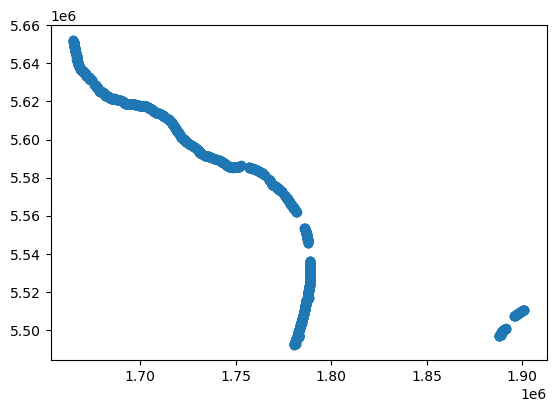

In [30]:
results.plot()
plt.show()

In [31]:
#Only run this code if value in group column is different for all rows
default_value = 1
column = 'group'
df = results
results[column] = default_value
results

,TransectID,slope,intercept,group,r2_score,mae,mse,rmse,BaselineID,Year,ocean_point,linear_model_point,linear_model_predicted_distance,linear_model_distance
0,1.0,-0.065571,-15.941371,1,0.926099,0.504336,0.276915,0.526227,0,2100,POINT (1664328.124468866 5651962.524324183),POINT (1664826.994 5652036.248),-26.432663,-4.287337
1,2.0,-0.090784,-11.259434,1,0.957393,0.507380,0.296034,0.544090,0,2100,POINT (1664336.6681260406 5651855.257598402),POINT (1664836.140 5651937.240),-25.784842,-6.155158
2,3.0,-0.055217,-15.562882,1,0.589842,1.023301,1.711207,1.308131,0,2100,POINT (1664335.6734834635 5651752.936539125),POINT (1664832.444 5651836.815),-24.397640,-3.802360
3,4.0,-0.056033,-15.276985,1,0.686399,0.931125,1.157774,1.075999,0,2100,POINT (1664348.616885819 5651632.510409517),POINT (1664841.538 5651737.691),-24.242237,-4.017763
4,5.0,-0.078909,-13.214268,1,0.760956,1.230886,1.578735,1.256477,0,2100,POINT (1664374.274382625 5651537.380842645),POINT (1664869.194 5651642.694),-25.839709,-6.000291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,1889.0,0.697474,-177.961444,1,0.987077,2.072922,5.907112,2.430455,243,2100,POINT (1900819.7878661277 5510122.869685081),POINT (1900807.557 5510582.381),-66.365529,40.325529
1849,1890.0,0.504762,-137.189692,1,0.940043,3.120928,15.071875,3.882251,243,2100,POINT (1900914.2821657087 5510166.770838147),POINT (1900897.744 5510639.654),-56.427705,26.827705
1850,1891.0,0.679716,-170.487991,1,0.926667,4.969595,33.909953,5.823225,243,2100,POINT (1901012.007003875 5510196.853486324),POINT (1900994.982 5510659.607),-61.733454,36.933454
1851,1892.0,0.691427,-179.334549,1,0.907356,5.639613,45.272000,6.728447,243,2100,POINT (1901220.5738396354 5510268.73627425),POINT (1901089.876 5510715.286),-68.706285,34.716285


In [32]:
results = prediction_results_to_polygon(results)
output_shapefile = "Manuwatu_Test/projection_output.shp"
results.to_file(output_shapefile, driver="ESRI Shapefile")

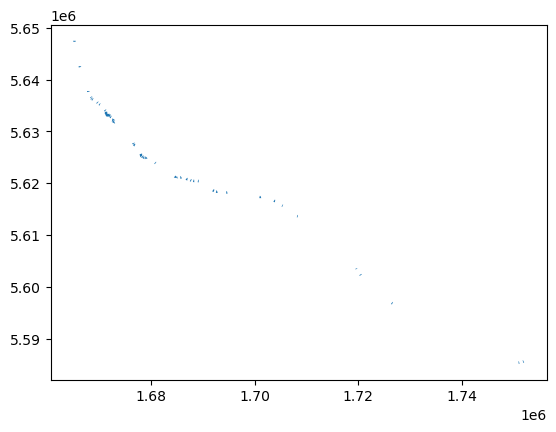

In [72]:
results.plot()
plt.show()